# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

***

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import datetime
import holidays
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy import interpolate

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

import warnings
from sklearn.decomposition import PCA
from scipy.optimize import fsolve
# %matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from my_cmds import *

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

In [3]:
DATE = '2024-10-31'
SHEET = 'selected quotes'

filepath = f'../data/treasury_quotes_{DATE}.xlsx'
quotes = pd.read_excel(filepath, sheet_name=SHEET).set_index('KYTREASNO')

In [7]:
quotes.columns

Index(['type', 'quote date', 'issue date', 'maturity date', 'ttm',
       'accrual fraction', 'cpn rate', 'bid', 'ask', 'price', 'accrued int',
       'dirty price', 'ytm'],
      dtype='object')

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [3]:
CF = calc_cashflows(quotes)

In [4]:
CF

,2025-04-30,2025-10-30,2025-10-31,2026-04-30,2026-10-30,2026-10-31,2027-04-30,2027-10-30,2027-10-31,2028-04-30,...,2028-10-31,2029-04-30,2029-10-30,2029-10-31,2030-04-30,2030-10-30,2030-10-31,2031-04-30,2031-10-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208042,101.9375,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
208129,2.5000,2.5000,100.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
208213,2.4375,2.4375,0.0,102.4375,0.0000,0.0,0.0000,0.0000,0.0,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
208302,2.0625,2.0625,0.0,2.0625,2.0625,100.0,0.0000,0.0000,0.0,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
207875,1.3750,1.3750,0.0,1.3750,1.3750,0.0,101.3750,0.0000,0.0,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
207960,2.0625,2.0625,0.0,2.0625,2.0625,0.0,2.0625,2.0625,100.0,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
208044,1.7500,1.7500,0.0,1.7500,1.7500,0.0,1.7500,1.7500,0.0,101.7500,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
208132,2.4375,2.4375,0.0,2.4375,2.4375,0.0,2.4375,2.4375,0.0,2.4375,...,100.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
208216,2.3125,2.3125,0.0,2.3125,2.3125,0.0,2.3125,2.3125,0.0,2.3125,...,0.0,102.3125,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0


In [6]:
CF = CF.resample('m',axis=1).sum()
CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
CF = CF.fillna(0).sort_index(axis=1)
CF

/var/folders/2v/x2l6x6852t599bjnhqck84ch0000gn/T/ipykernel_98658/3180780813.py:1: FutureWarning: DataFrame.resample with axis=1 is deprecated. Do `frame.T.resample(...)` without axis instead.
  CF = CF.resample('m',axis=1).sum()
/var/folders/2v/x2l6x6852t599bjnhqck84ch0000gn/T/ipykernel_98658/3180780813.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  CF = CF.resample('m',axis=1).sum()


,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
KYTREASNO,,,,,,,,,,,,,,
208042,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208129,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208213,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208302,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207875,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207960,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208044,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208132,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208216,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [9]:
MODEL = bootstrap
params = estimate_rate_curve(MODEL,CF,pd.to_datetime(DATE),quotes['dirty price'],x0=None)

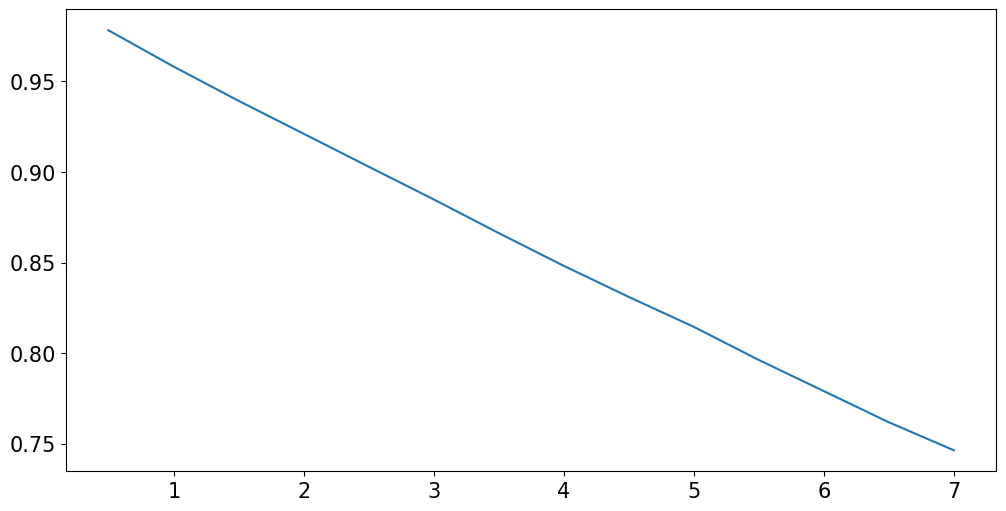

In [11]:
plt.plot(params[0], params[1])
plt.show()

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

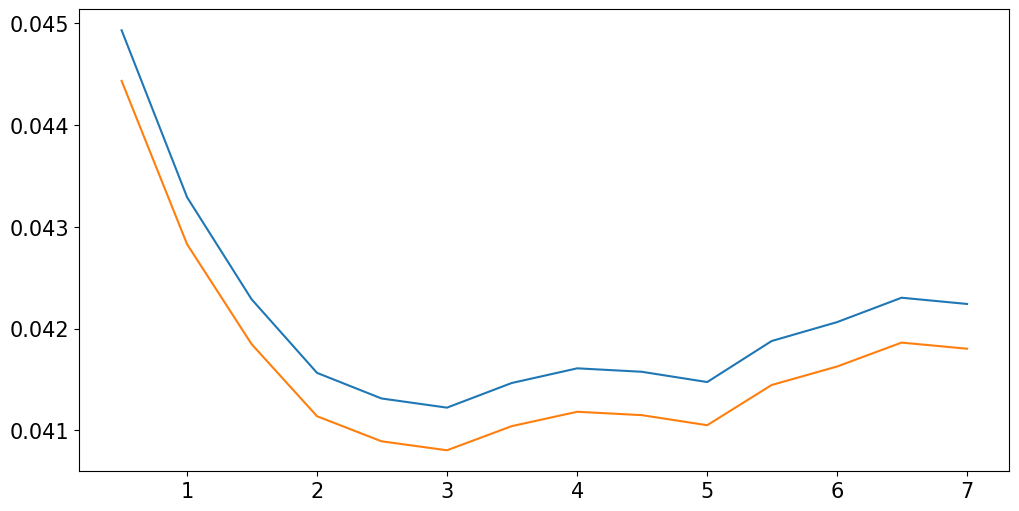

In [32]:
rates1 = discount_to_intrate(params[1], params[0], n_compound=2)
rates2 = discount_to_intrate(params[1], params[0], n_compound=None)
plt.plot(params[0], rates1)
plt.plot(params[0], rates2)
plt.show()

### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [37]:
CF_new = CF + 0.005/2 * 100 * (CF>0)
rates_new =rates1+0.005

In [38]:
(CF_new @ disc_new)

KYTREASNO
208042     99.720256
208129    100.648984
208213    100.942717
208302     99.937669
207875     96.790333
207960    100.003602
208044     97.942614
208132    102.575685
208216    101.891044
208305     99.895547
208046     96.729711
208133    103.494654
208217    102.254743
208306     99.459919
dtype: float64

In [39]:
# disc_new = intrate_to_discount(rates1,params[0],n_compound=2)

pxadj = pd.DataFrame(CF_new @ disc_new, columns=['price adjusted'], index=CF_new.index)
px = quotes['dirty price'].loc[pxadj.index]
price_comp = pd.concat([px,pxadj],axis=1)
price_comp.style.format('{:.2f}')

,dirty price,price adjusted
KYTREASNO,,
208042,99.72,99.72
208129,100.65,100.65
208213,100.95,100.94
208302,99.94,99.94
207875,96.77,96.79
207960,100.00,100.00
208044,97.92,97.94
208132,102.60,102.58
208216,101.91,101.89


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

In [4]:
SHEET = 'quotes'

filepath = f'../data/treasury_quotes_{DATE}.xlsx'
quotes = pd.read_excel(filepath, sheet_name=SHEET).set_index('KYTREASNO')

t_current = quotes['quote date'].values[0]

CFset = dict()

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [41]:
# quotes_filtered = filter_treasuries(quotes, t_date=t_current, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True)

In [5]:
CF_1 = calc_cashflows(quotes, filter_maturity_dates=False)

In [6]:
CF_1.head()

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0.0,100.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0.0,0.0,100.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0.0,0.0,0.0,100.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0.0,0.0,0.0,0.0,103.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
CF_1.tail()

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208149,0.0,0.0,0.0,0.0,2.3750,0.0,0.0,0.0,0.0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.0000,0.0000,0.000
208191,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,1.0625,0.0000,1.0625,0.0000,1.0625,0.0000,101.0625,0.0000,0.000
208178,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.1250,0.0000,0.000
208233,0.0,0.0,0.0,0.0,2.3125,0.0,0.0,0.0,0.0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,102.3125,0.000
208279,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125


In [8]:
# Find the column with the largest sum
largest_sum_column = CF_1.sum().idxmax()

# Find the column with the most non-zero entries
most_nonzero_column = (CF_1 != 0).sum().idxmax()

print(f"Date paying the most cash: {largest_sum_column:%Y-%m-%d}")
print(f"Date with the most paying bonds: {most_nonzero_column:%Y-%m-%d}")

Date paying the most cash: 2025-02-15
Date with the most paying bonds: 2025-02-15


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [9]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

label = 'no non-maturity dates'

data = filter_treasuries(quotes, t_date=t_current, filter_yld = True, filter_tips = True, drop_duplicate_maturities=False)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=True)
CFset[label] = CF

display(CF)

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208222,0.0,100.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208247,0.0,0.0,100.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
208223,0.0,0.0,0.0,100.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
204083,0.0,0.0,0.0,0.0,103.7500,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208105,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375,0.0000,0.0000,0.0000,0.0000
208147,0.0,0.0,0.0,0.0,2.2500,0.0,0.0,0.0,0.0,0.0,...,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.0000
208177,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,102.0000,0.0000,0.0000


In [10]:
params = estimate_rate_curve(MODEL,CF,t_current,data['dirty price'],x0=None)

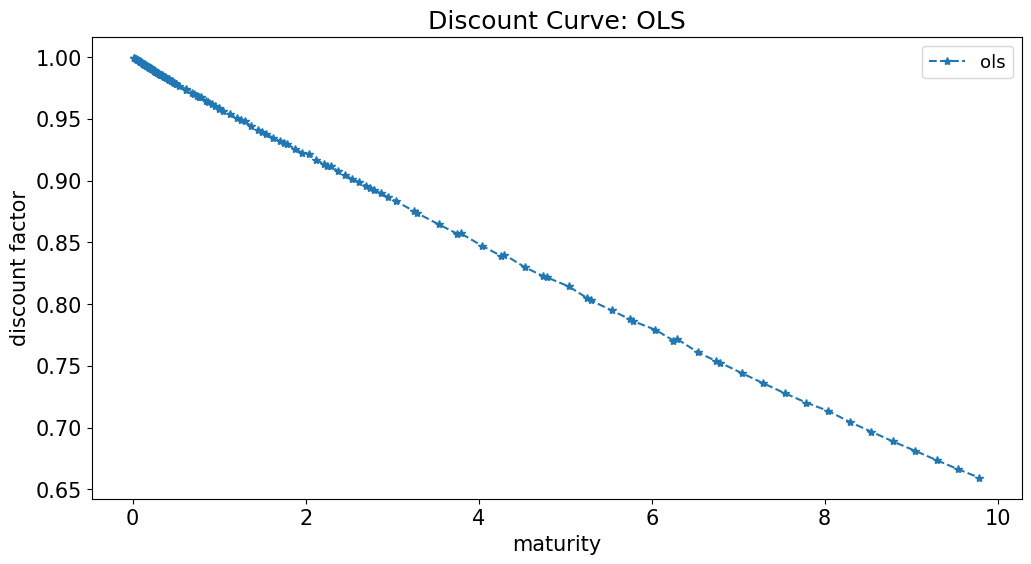

In [11]:
# params_OLS = estimate_rate_curve(MODEL,CF,t_current,quotes['dirty price'].loc[CF.index])
disc_ols = pd.DataFrame({'maturity':params[0], 'ols': params[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

In [12]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(quotes, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
CFset['all dates'] = CF
prices = quotes['dirty price'].loc[CF.index]

In [13]:
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices)

In [14]:
params_NS

array([ 0.04789018, -0.00223678, -0.02037401,  2.12694376])

In [15]:
maturity_list = get_maturity_delta(CF.columns,t_current=t_current)
maturity_grid = np.arange(0.5,maturity_list.max()+.5,0.5)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)

In [16]:
curves_ols = pd.DataFrame(index = params[0])
curves_ols['ols'] = bootstrap(params,params[0])

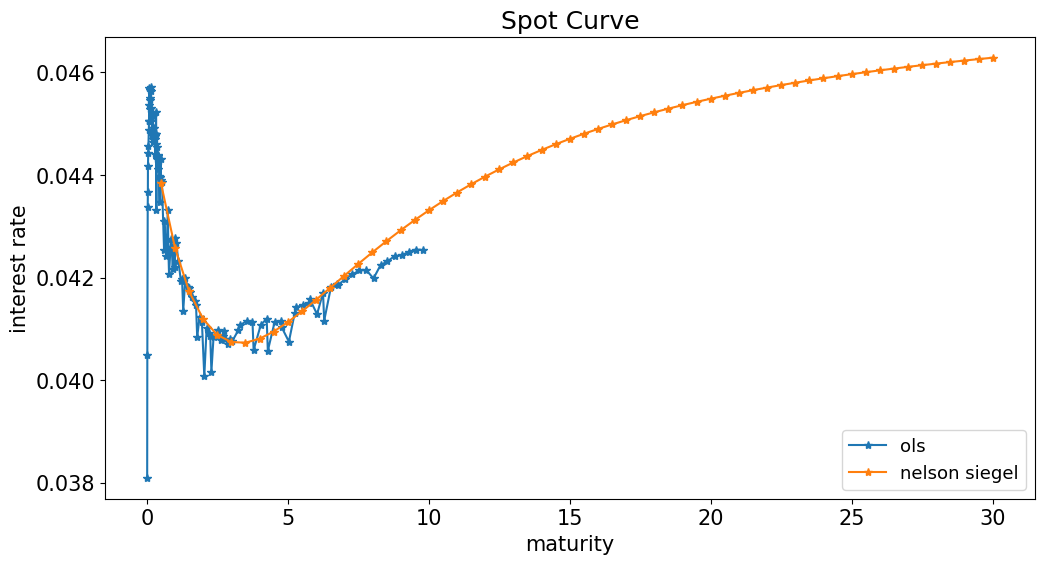

In [17]:
ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*')

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [83]:
from sklearn.decomposition import PCA

In [18]:
filepath = '../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)

shapes = pd.DataFrame(yields.mean(axis=1),columns=['level'])
shapes['slope'] = yields[30]-yields[1]
shapes['curvature'] = -yields[1] + 2 * yields[10] - yields[30]

DATETHRESH = '2010-01-01'
shapesT = shapes[shapes.index>DATETHRESH]

In [19]:
shapes.corr()

,level,slope,curvature
level,1.000000,-0.371060,-0.162638
slope,-0.371060,1.000000,0.650691
curvature,-0.162638,0.650691,1.000000


In [20]:
shapes.describe()

,level,slope,curvature
count,15868.000000,15868.000000,15868.000000
mean,5.463678,1.098446,0.660265
std,2.903979,1.478564,0.975464
min,0.487603,-3.490292,-5.426753
25%,3.464977,-0.021420,0.074945
50%,5.154073,0.997652,0.615611
75%,7.149205,2.109713,1.328883
max,15.259628,4.358273,3.283792


### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [21]:
pca = PCA(svd_solver='full')
pca.fit(yields)
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance explained']).T
pca_var_explained.columns = list(np.arange(1,8,1))
pca_var_explained.style.format('{:.2%}'.format)

,1,2,3,4,5,6,7
Variance explained,97.05%,2.55%,0.30%,0.05%,0.04%,0.02%,0.01%


In [22]:
pca.components_[:2]

array([[ 0.41095402,  0.41080346,  0.39285302,  0.37851639,  0.36358955,
         0.3442573 ,  0.33769618],
       [ 0.59331747,  0.39942751,  0.04530879, -0.08905105, -0.20378575,
        -0.43688619, -0.49603517]])

### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [23]:
pca_wts = pd.DataFrame(pca.components_,columns=yields.columns)
pca_wts

,1,2,5,7,10,20,30
0,0.410954,0.410803,0.392853,0.378516,0.363590,0.344257,0.337696
1,0.593317,0.399428,0.045309,-0.089051,-0.203786,-0.436886,-0.496035
2,0.453675,0.004998,-0.392959,-0.447852,-0.361832,0.365625,0.417806
3,0.357274,-0.386427,-0.372258,-0.103582,0.740588,-0.067918,-0.143668
4,-0.021274,-0.014334,0.017353,-0.011005,-0.051234,0.742868,-0.666665
5,0.340060,-0.571384,-0.012209,0.642821,-0.379775,-0.016809,0.000960
6,0.171851,-0.442338,0.741735,-0.473450,-0.005186,-0.013685,0.016298


In [24]:
yields

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018
...,...,...,...,...,...,...,...
2024-12-24,4.263383,4.288041,4.395862,4.481357,4.531450,4.842907,4.712979
2024-12-26,4.245134,4.282515,4.378693,4.460309,4.522614,4.836411,4.712016
2024-12-27,4.220121,4.268950,4.404594,4.493999,4.567839,4.888583,4.763756


In [25]:
pca_factors = yields @ pca_wts.T

In [26]:
pca_factors

,0,1,2,3,4,5,6
caldt,,,,,,,
1961-06-14,9.427121,-1.424204,-0.156244,0.031948,0.005137,-0.054228,-0.088338
1961-06-15,9.489326,-1.441303,-0.198485,0.033398,0.006131,-0.059012,-0.077260
1961-06-16,9.496155,-1.446733,-0.202067,0.026885,0.007434,-0.059937,-0.067234
1961-06-19,9.530949,-1.459483,-0.227752,0.021014,0.008531,-0.067309,-0.064436
1961-06-20,9.520727,-1.464235,-0.187763,0.055533,0.013505,-0.046889,-0.057204
...,...,...,...,...,...,...,...
2024-12-24,11.843140,-1.334645,0.321412,0.115510,0.098300,0.028921,-0.038196
2024-12-26,11.812885,-1.341467,0.329699,0.113733,0.094970,0.016016,-0.041539
2024-12-27,11.871836,-1.421227,0.317346,0.119423,0.097721,0.018598,-0.036681


In [27]:
pd.concat([shapes, pca_factors.iloc[:,0:3]], axis=1, keys=['shapes', 'pca']).corr().loc['shapes', 'pca'].style.format('{:.1%}')

,0,1,2
level,100.0%,-1.2%,0.1%
slope,-38.2%,-92.0%,-1.0%
curvature,-17.0%,-64.6%,-69.8%
